In [1]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Base libraries
import numpy as np
import pandas as pd
from typing import Tuple
from scipy.stats import norm

# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate

# import warnings
# warnings.filterwarnings('ignore')

In [3]:
class BS:
    def __init__(self, spot, strike, rate, dte, volatility):
        self.S = spot
        self.K = strike
        self.r = rate
        self.t = dte
        self.sigma = volatility
        
        # Calculate common terms used across methods
        self.time_sqrt = np.sqrt(self.t)
        self.discount_factor = np.exp(-self.r * self.t)
       
        # Calculate d1 and d2 parameters
        self.d1 = self._calculate_d1()
        self.d2 = self.d1 - self.sigma * self.time_sqrt
        
        # Calculate all option Greeks and prices
        self.call_price, self.put_price = self._price()
        self.call_delta, self.put_delta = self._delta()
        self.gamma = self._gamma()
        self.vega = self._vega()
        self.call_theta, self.put_theta = self._theta()
        self.call_rho, self.put_rho = self._rho()
       
    def _calculate_d1(self) -> float:
        return (np.log(self.S / self.K) + (self.r + (self.sigma**2) / 2) * self.t) / (
            self.sigma * self.time_sqrt
        )
    
    def _price(self) -> Tuple[float, float]:
        d1_cdf = norm.cdf(self.d1)
        d2_cdf = norm.cdf(self.d2)

        call = self.S * d1_cdf - self.K * self.discount_factor * d2_cdf
        put = self.K * self.discount_factor * norm.cdf(-self.d2) - self.S * norm.cdf(
            -self.d1
        )
        return call, put
    
    def _delta(self) -> Tuple[float, float]:
        d1_cdf = norm.cdf(self.d1)
        return d1_cdf, -norm.cdf(-self.d1)
    
    def _gamma(self) -> float:
        return norm.pdf(self.d1) / (self.S * self.sigma * self.time_sqrt)
    
    def _vega(self) -> float:
        return self.S * norm.pdf(self.d1) * self.time_sqrt / 100
    
    def _theta(self) -> Tuple[float, float]:
        spot_term = -self.S * norm.pdf(self.d1) * self.sigma / (2 * self.time_sqrt)
        call_rate_term = -self.r * self.K * self.discount_factor * norm.cdf(self.d2)
        put_rate_term = self.r * self.K * self.discount_factor * norm.cdf(-self.d2)

        return (spot_term + call_rate_term) / 365, (spot_term + put_rate_term) / 365
    
    def _rho(self) -> Tuple[float, float]:
        call = self.K * self.t * self.discount_factor * norm.cdf(self.d2) / 100
        put = -self.K * self.t * self.discount_factor * norm.cdf(-self.d2) / 100
        return call, put

In [4]:
# Initialize option
option = BS(100,100,0.05,1,0.2)

header = ['Type', 'Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [
    [
        'Call',
        option.call_price,
        option.call_delta,
        option.gamma,
        option.call_theta,
        option.vega,
        option.call_rho
    ],
    [   
        'Put',
        option.put_price,
        option.put_delta,
        option.gamma,
        option.put_theta,
        option.vega,        
        option.put_rho       
    ],
]

print(tabulate(table,header))

Type      Option Price      Delta     Gamma        Theta     Vega        Rho
------  --------------  ---------  --------  -----------  -------  ---------
Call          10.4506    0.636831  0.018762  -0.0175727   0.37524   0.532325
Put            5.57353  -0.363169  0.018762  -0.00454214  0.37524  -0.418905


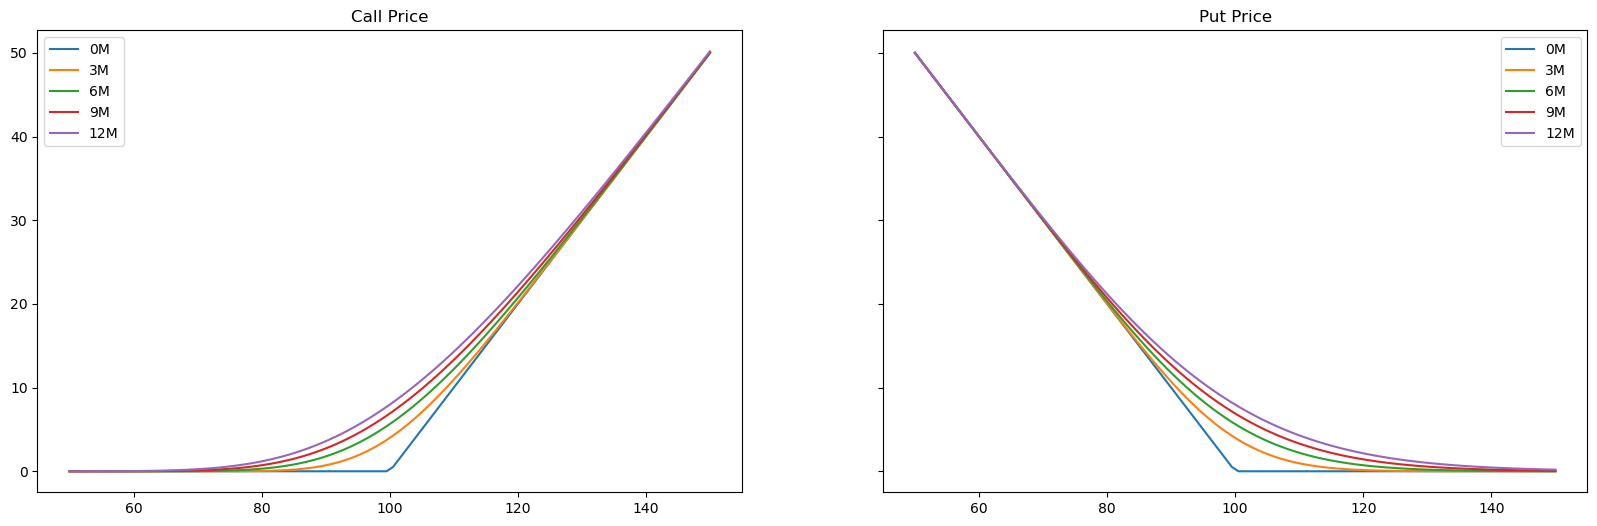

In [5]:
# Plot option values for range of spot prices over differece time
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Define expirations and labels
d = {'0M': 1e-50, '3M': 0.25, '6M': 0.5, '9M': 0.75, '12M': 1.0}
x = np.linspace(50, 150, 100)

# Plot call and put prices
for label, tau in d.items():
    bs = BS(x, 100, 0.0, tau, 0.2)
    axes[0].plot(x, bs.call_price, label=label)
    axes[1].plot(x, bs.put_price, label=label)

# Set titles and legends
for ax, title in zip(axes, ["Call Price", "Put Price"]):
    ax.set_title(title)
    ax.legend()

plt.show()


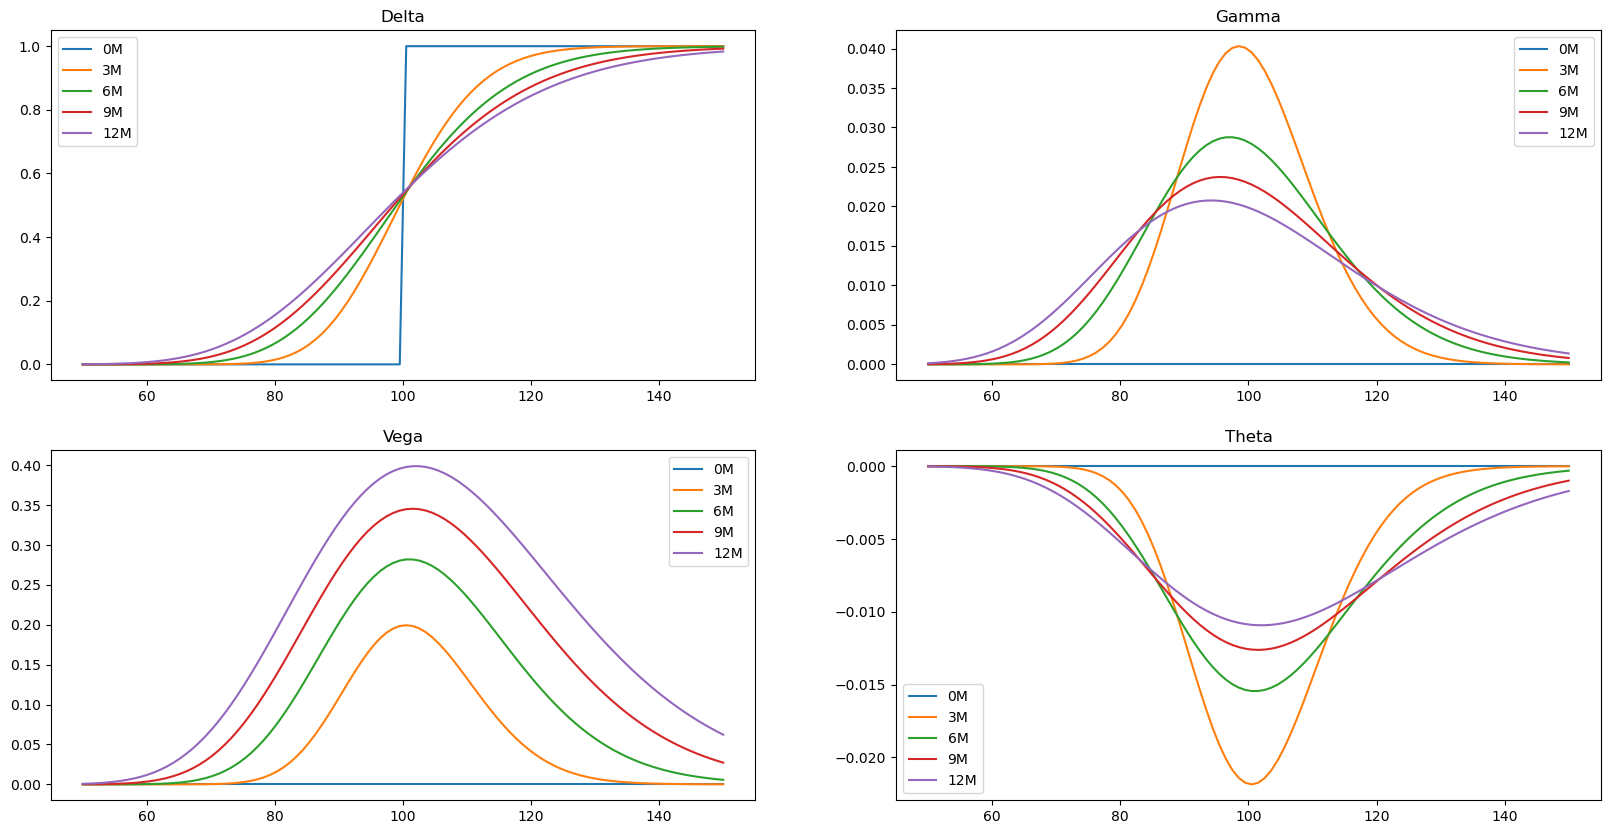

In [6]:
# Plot graph iteratively
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Define Greeks and their respective subplot positions
greeks = {
    (0, 0): ('call_delta', 'Delta'),
    (0, 1): ('gamma', 'Gamma'),
    (1, 0): ('vega', 'Vega'),
    (1, 1): ('call_theta', 'Theta')
}

# Plot all Greeks in one loop
for (i, j), (attr, title) in greeks.items():
    for label, tau in d.items():
        ax[i, j].plot(x, getattr(BS(x, 100, 0.0, tau, 0.2), attr), label=label)
    ax[i, j].set_title(title)
    ax[i, j].legend()

plt.show()

